In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
from matplotlib import pyplot as plt
from numpy.polynomial import polynomial
from sklearn.linear_model import LinearRegression
import copy

# Functions

In [2]:
def doy_helper(ds):
    # Remove leap day (Feb 29)
    # ds = ds.isel(
    #     time=~((pd.to_datetime(ds.time).day == 29)&(pd.to_datetime(ds.time).month == 2))
    # )
    years = np.array([ds.time.values[i].year for i in range(len(ds.time))])
    # Create day of year (DOY) array for indexing
    doy = np.tile(
        np.arange(1, 366, 1, dtype='int32'),
        len(np.unique(years))
    )

    # rework dims/coords for climo
    return ds.rename({'time':'doy'}).assign_coords({'doy':('doy', doy)})

def return_from_doy_helper(dswdoy, dswtime):

    # Remove leap day (Feb 29)
    # dswtime = dswtime.isel(
    #     time=~((pd.to_datetime(dswtime.time).day == 29)&(pd.to_datetime(dswtime.time).month == 2))
    # )

    # save time coord
    time_arr = dswtime.time.values

    # reverse to time instead of doy
    return dswdoy.assign_coords({'doy':('doy', time_arr)}).rename({'doy':'time'})

def get_climatology_smoothed(ds, var, window=60, fileauthor='Jhayron S. Pérez-Carrasquilla'):
    
    # Subset dataset for the period 1981-2020
    ds_clima = ds

    # adjust to doy coords/dims
    ds_clima = doy_helper(ds_clima)
    
    # Compute the daily mean for each day of the year
    climo = []
    for i in range(1, 366):
        daily_mean = ds_clima.sel(doy=i)[var].mean('doy')
        climo.append(daily_mean)
    
    # Convert to xarray Dataset with the appropriate dimensions
    attrs = ds[var].attrs
    attrs['File Author'] = fileauthor
    
    climo = xr.Dataset({
        f'{var}_climo': (['doy', 'lat', 'lon'], np.array(climo)),
    }, 
    coords={
        'doy': np.arange(1, 366, 1),
        'lat': ds.lat.values,
        'lon': ds.lon.values,
    },
    attrs=attrs
    )

    # reorder dims
    climo = climo.transpose('doy', 'lat', 'lon')

    # sanity check
    # print(climo[f'{var}_climo'].shape)
    
    # Stack climatology 3 times to handle edges
    climo_extended = xr.concat([climo, climo, climo], dim='doy')

    # Adjust coordinates after stacking to represent a larger time span
    climo_extended['doy'] = np.arange(1, 365 * 3 + 1, 1)

    # Apply rolling mean with a 60-day window for smoothing
    climo_smoothed = climo_extended.rolling(doy=window, center=True, min_periods=1).mean(skipna=True)

    # Extract the middle portion, corresponding to the original 365 days
    climo_smoothed = climo_smoothed.isel(doy=slice(365, 365 + 365))

    # sanity check
    # print(climo_smoothed[f'{var}_climo'].shape)
    
    # Reset 'day_of_year' coordinate to original range
    climo_smoothed['doy'] = np.arange(1, 366, 1)

    return climo_smoothed

def get_anomalies(ds, var, climo):

    # deep copy dataset
    anom = copy.deepcopy(ds)

    # adjust to doy coords/dims
    dstmp = doy_helper(ds)
    anom = doy_helper(anom)

    # compute doy anomalies
    for day in range(1, 366):
        
        anom[var][{'doy':(dstmp.doy == day)}] = (dstmp[var].sel(doy=day) - climo[f'{var}_climo'].sel(doy=day))

    # back to dataset
    anom = anom.rename({var:f'{var}_anom'})

    # add original time dim
    return return_from_doy_helper(anom, ds)

def fourierfilter(da, cutoff_period=10):
    
    # Compute the Fourier transform along the time axis
    fft_data = np.fft.fft(da, axis=0)
    
    # Get the frequencies corresponding to the FFT components
    freqs = np.fft.fftfreq(da.shape[0], d=1)
    # d=1 assumes daily data; adjust if different
    
    # Compute the corresponding periods (in days)
    periods = np.abs(1 / freqs)
    
    # Define the cutoff period for low-pass filter (10 days)
    cutoff_period = cutoff_period
    
    # Create a mask to filter out high-frequency components (shorter than 10 days)
    high_pass_mask = periods < cutoff_period
    
    # Apply the mask to the FFT data (set high-frequency components to zero)
    fft_data_filtered = fft_data.copy()
    fft_data_filtered[high_pass_mask, :, :] = 0
    
    # Perform the inverse FFT to get the filtered data back in the time domain
    filtered_data = np.fft.ifft(fft_data_filtered, axis=0).real
    
    # Create a new xarray DataArray to store the filtered data
    filtered_anom = xr.DataArray(
        filtered_data,
        dims=da.dims,
        coords=da.coords,
        attrs=da.attrs
    )
    return filtered_anom

# Get average time series of the region
def get_weighted_area_average(da):
    
    # Compute the cosine of the latitudes (in radians) for weighting
    # For a rectangular grid the cosine of the latitude is proportional to the grid cell area
    weights = np.cos(np.deg2rad(da.lat))
    weights.name = "weights"

    # Apply the weights and compute the mean across lat/lon
    da_weighted = da.weighted(weights)
    weighted_mean = da_weighted.mean(dim=['lat', 'lon'])
    
    return weighted_mean


def create_doy_dummy(num_yr=84):
    """Creates dummy array for indexing the non-leap year based doy time series"""
    days_per_year = 365
    years = num_yr
    day_indices = np.arange(
        0, 
        years * days_per_year, 
        days_per_year,
        dtype=int
    ).reshape(-1, 1) + np.arange(days_per_year)
    return day_indices


def get_climatology_std_smoothed(ds, var, window=60, fileauthor='Jhayron S. Pérez-Carrasquilla'):

    # Get the day of year (DOY)
    doy_tmp = create_doy_dummy(len(np.unique(years_full)))
    
    # Compute the daily standard deviation for each day of the year
    climo = []
    for i in range(0, 365):
        # grab indices for doy
        doy_indx = doy_tmp[:, i]
        
        # ensure time is first axis with transpose
        array_temp = ds[var].transpose('time', 'lat', 'lon')[doy_indx]

        # compute std for doy
        std = np.nanstd(array_temp, axis=0)
        # make nan where 0
        std[std == 0] = np.nan
        climo.append(std)
    
    # Convert to xarray Dataset with the appropriate dimensions
    attrs = ds[var].attrs
    attrs['File Author'] = fileauthor
    
    climo = xr.Dataset({
        f'{var}_climo_std': (['doy', 'lat', 'lon'], np.array(climo)),
    }, 
    coords={
        'doy': np.arange(1, 366, 1),
        'lat': ds.lat.values,
        'lon': ds.lon.values,
    },
    attrs=attrs)

    climo = climo.transpose('doy', 'lat', 'lon')
    
    # Stack climatology 3 times to handle edges
    climo_extended = xr.concat([climo, climo, climo], dim='doy')

    # Adjust coordinates after stacking to represent a larger time span
    climo_extended['doy'] = np.arange(1, 365 * 3 + 1, 1)

    # Apply rolling mean with a 60-day window for smoothing
    climo_smoothed = climo_extended.rolling(doy=window, center=True, min_periods=1).mean(skipna=True)

    # Extract the middle portion, corresponding to the original 365 days
    climo_smoothed = climo_smoothed.isel(doy=slice(365, 365 + 365))

    # Reset 'day_of_year' coordinate to original range
    climo_smoothed['doy'] = np.arange(1, 366, 1)

    return climo_smoothed

# this func is not used (below)
def standardize_anomalies(anom, var, climo_std):

    # ensure time is first dim/axis
    anom = anom.transpose('time', 'lat', 'lon')
    std_anom = copy.deepcopy(anom)
    
    # Get the day of year (DOY)
    doy_tmp = create_doy_dummy(len(np.unique(years_full)))

    for i in range(0, 365):
        
        doy_indx = doy_tmp[:, i]

        std_anom[var][doy_indx] = (
            anom[var][doy_indx] / climo_std[f'{var}_climo_std'].sel(doy=i + 1)
        )
    return std_anom

In [3]:
def extractz500_several_files(filestemp):
    listxarrays = []
    for file in filestemp:
        dstemp = xr.open_dataset(file)
        # dstemp = dstemp.sel(time=slice('1850-01-01', '2100-12-31'))
        dstemp = dstemp.Z500.where((dstemp.lat>=10),drop=True)
        # Transpose the data to match the desired dimension order
        dstemp_transposed = dstemp.transpose('time', 'lat', 'lon')
        lat0=20; lat1=80; lon0=180; lon1=330
        dstemp_transposed = dstemp_transposed.where((dstemp_transposed.lat>=lat0)&(dstemp_transposed.lat<=lat1)&\
                               (dstemp_transposed.lon>=lon0)&(dstemp_transposed.lon<=lon1),drop=True)
        
        # Recreate the DataArray with the coordinates in the desired order
        dstemp_reordered = xr.DataArray(
            dstemp_transposed.values,
            dims=['time', 'lat', 'lon'],
            coords={
                'time': dstemp_transposed.coords['time'],
                'lat': dstemp_transposed.coords['lat'],
                'lon': dstemp_transposed.coords['lon']
            },
            attrs=dstemp.attrs,
            name=dstemp.name
        )
        listxarrays.append(dstemp_reordered)
    xarrayfull = xr.concat(listxarrays, dim='time')
    xarrayfull = xarrayfull.drop_duplicates('time',keep='first')
    cftime_index = xr.coding.cftimeindex.CFTimeIndex(xarrayfull['time'].values)
    datetime_index = cftime_index.to_datetimeindex()
    xarrayfull.coords['time'] = datetime_index
    return xarrayfull.to_dataset()

# Compute anomalies

In [6]:
path_files = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/day/zg/gn/latest/'
filenames = np.sort(glob.glob(f'{path_files}*.nc'))

In [7]:
len(filenames)

100

In [8]:
path_outputs_anoms = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/CESM2_4xCO2_Z500_Anoms/'

In [23]:
filestemp = filenames
listxarrays = []
for file in filestemp:
    dstemp = xr.open_dataset(file)
    # dstemp = dstemp.sel(time=slice('1850-01-01', '2100-12-31'))
    dstemp = dstemp.zg.where((dstemp.lat>=10),drop=True)
    dstemp = dstemp.sel(plev=50000)
    # Transpose the data to match the desired dimension order
    dstemp_transposed = dstemp.transpose('time', 'lat', 'lon')
    lat0=20; lat1=80; lon0=180; lon1=330
    dstemp_transposed = dstemp_transposed.where((dstemp_transposed.lat>=lat0)&(dstemp_transposed.lat<=lat1)&\
                           (dstemp_transposed.lon>=lon0)&(dstemp_transposed.lon<=lon1),drop=True)
    
    # Recreate the DataArray with the coordinates in the desired order
    dstemp_reordered = xr.DataArray(
        dstemp_transposed.values,
        dims=['time', 'lat', 'lon'],
        coords={
            'time': dstemp_transposed.coords['time'],
            'lat': dstemp_transposed.coords['lat'],
            'lon': dstemp_transposed.coords['lon']
        },
        attrs=dstemp.attrs,
        name=dstemp.name
    )
    listxarrays.append(dstemp_reordered)

xarrayfull = xr.concat(listxarrays, dim='time')
xarrayfull = xarrayfull.drop_duplicates('time',keep='first')
xarrayfull.to_netcdf('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/CESM2_4xCO2/Z500.nc')

/glade/work/jhayron/conda-envs/pytorch_wr/lib/python3.12/site-packages/xarray/conventions.py:287: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/glade/work/jhayron/conda-envs/pytorch_wr/lib/python3.12/site-packages/xarray/conventions.py:287: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/glade/work/jhayron/conda-envs/pytorch_wr/lib/python3.12/site-packages/xarray/conventions.py:287: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/glade/work/jhayron/conda-envs/pytorch_wr/lib/python3.12/site-packages/xarray/conventions.py:287: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/glade/w

In [25]:
xarrayfull = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/CESM2_4xCO2/Z500.nc')

In [27]:
# xarrayfull = xarrayfull.drop_duplicates('time',keep='first')
# cftime_index = xr.coding.cftimeindex.CFTimeIndex(xarrayfull['time'].values)
# datetime_index = cftime_index.to_datetimeindex()
# xarrayfull.coords['time'] = datetime_index

In [28]:
lat0=20; lat1=80; lon0=180; lon1=330
dataset_region = xarrayfull.where(
    (
        xarrayfull.lat>=lat0)&(
            xarrayfull.lat<=lat1)&(
            xarrayfull.lon>=lon0)&(
            xarrayfull.lon<=lon1),
    drop=True
)

In [29]:
del(xarrayfull)

In [33]:
mean = dataset_region.zg.mean(dim=['lat','lon'])

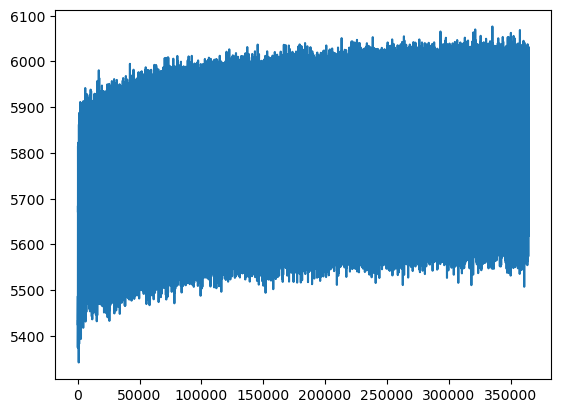

In [40]:
plt.plot(mean)

In [31]:
clima = get_climatology_smoothed(dataset_region, 'zg')

In [41]:
anoms = get_anomalies(dataset_region, 'zg', clima)

In [42]:
anoms_filtered = fourierfilter(anoms.zg_anom)

/glade/derecho/scratch/jhayron/tmp/ipykernel_66436/1559490235.py:114: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


In [15]:
del(anoms)
del(clima)

In [16]:
anoms_filtered = anoms_filtered.to_dataset(name='Z_anom')

In [48]:
anoms_filtered.to_netcdf('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/CESM2_4xCO2/pi_Z500anoms_filtered.nc')

In [43]:
anoms_smooth = copy.deepcopy(anoms_filtered).rolling(time=60, center=True, min_periods=1).mean(skipna=True)


In [49]:
anoms_smooth.to_netcdf('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/CESM2_4xCO2/pi_Z500anoms_smooth.nc')

In [47]:
mean_series = get_weighted_area_average(anoms_smooth)

In [46]:
anoms_smooth

<xarray.DataArray (time: 364635, lat: 64, lon: 121)> Size: 23GB
array([[[-218.20376025, -217.98429981, -217.82460704, ...,
         -245.88151457, -244.51230697, -243.1811663 ],
        [-218.51339837, -218.15506859, -217.8453827 , ...,
         -243.69831857, -241.9070832 , -240.36298747],
        [-219.38046913, -218.79178946, -218.32574593, ...,
         -240.64459787, -238.57222807, -236.83415045],
        ...,
        [-289.42811836, -288.73938352, -288.06282754, ...,
         -333.58689714, -334.74294654, -339.51736611],
        [-297.23842874, -296.69145073, -296.15612795, ...,
         -342.40218343, -346.19925078, -346.35162166],
        [-304.74773331, -304.41828581, -304.09323582, ...,
         -350.37478624, -349.99606392, -348.14404867]],

       [[-219.00991882, -218.70054636, -218.46025958, ...,
         -246.89722479, -245.52278592, -244.15604586],
        [-219.22451744, -218.76280165, -218.34335994, ...,
         -244.77164465, -242.98839913, -241.41328818],
        [-219.93483908, -219.2300046 , -218.63749401, ...,
         -241.73353163, -239.68798338, -237.93600575],
...
        [ -35.21957899,  -34.98851421,  -34.75360427, ...,
          -45.97625671,  -47.32951162,  -47.23456462],
        [ -33.54306121,  -33.52054443,  -33.51950413, ...,
          -43.31405972,  -43.05481184,  -42.50453894],
        [ -31.48870943,  -31.55225864,  -31.66049357, ...,
          -37.74052427,  -37.69021615,  -37.342133  ]],

       [[  67.70199447,   68.07388577,   68.40970539, ...,
           27.83019133,   27.55501519,   27.38616247],
        [  65.39269384,   65.82488137,   66.22921255, ...,
           27.1445369 ,   26.78909997,   26.51453242],
        [  62.47904536,   62.94781679,   63.45714204, ...,
           26.69173794,   26.22097221,   25.85483517],
        ...,
        [ -42.01292462,  -41.50006793,  -40.98382172, ...,
          -49.01394604,  -50.3491459 ,  -50.3117045 ],
        [ -40.21117629,  -39.93490188,  -39.68046407, ...,
          -46.12565166,  -45.91021573,  -45.37016051],
        [ -37.95767931,  -37.7949306 ,  -37.6771596 , ...,
          -40.31758487,  -40.29313716,  -39.95994426]]])
Coordinates:
  * lat      (lat) float64 512B 20.26 21.2 22.15 23.09 ... 77.75 78.69 79.63
  * lon      (lon) float64 968B 180.0 181.2 182.5 183.8 ... 327.5 328.8 330.0
  * time     (time) object 3MB 0001-01-01 00:00:00 ... 0999-12-31 00:00:00
Attributes: (12/20)
    cell_measures:  area: areacella
    cell_methods:   time: mean
    comment:        vinth2p(Z3,hyam,hybm,plev,PS,P0)
    description:    Geopotential is the sum of the specific gravitational pot...
    frequency:      day
    id:             zg
    ...             ...
    time_title:     Temporal mean
    title:          Geopotential Height
    type:           real
    units:          m
    variable_id:    zg
    File Author:    Jhayron S. Pérez-Carrasquilla

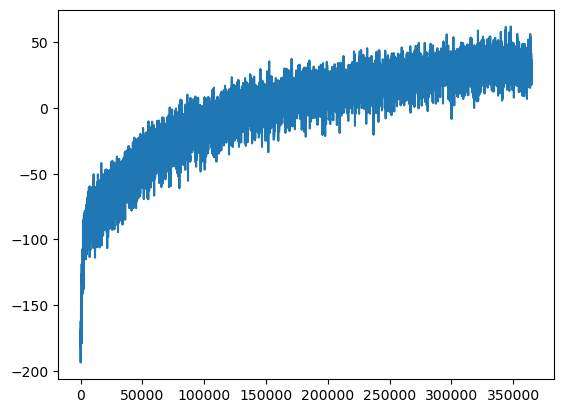

In [50]:
plt.plot(mean_series)

In [51]:
years_full = np.array([mean_series.time[i].time.values[()].year for i in range(len(mean_series.time))])

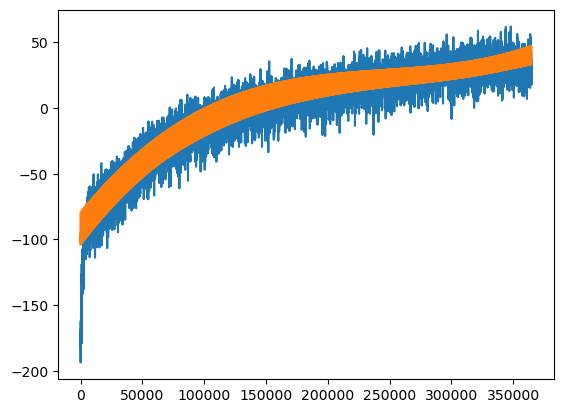

In [52]:
full_curve = copy.deepcopy(mean_series)
full_curve.data = np.zeros(len(full_curve))
npoly=3

doy_tmp = create_doy_dummy(len(np.unique(years_full)))

for i in range(0, 365): #Iterate through every day of the year

    doy_indx = doy_tmp[:, i]
    
    # fit a polynomial for the trend of each DOY
    params_curve = polynomial.polyfit(
        np.arange(0, mean_series[doy_indx].shape[0]), 
        mean_series[doy_indx], 
        npoly
    )
    curve = polynomial.polyval(
        np.arange(0, mean_series[doy_indx].shape[0]), 
        params_curve, 
        tensor=True
    )
    
    ## Center curve in zero
    full_curve.loc[{'time': mean_series[doy_indx].time}] = curve

plt.plot(mean_series)
plt.plot(full_curve)
plt.show()
plt.close('all')

In [56]:
anoms_detrended = anoms_filtered - full_curve.data[:, np.newaxis, np.newaxis]
anoms_detrended = anoms_detrended.to_dataset(name='Z_anom')

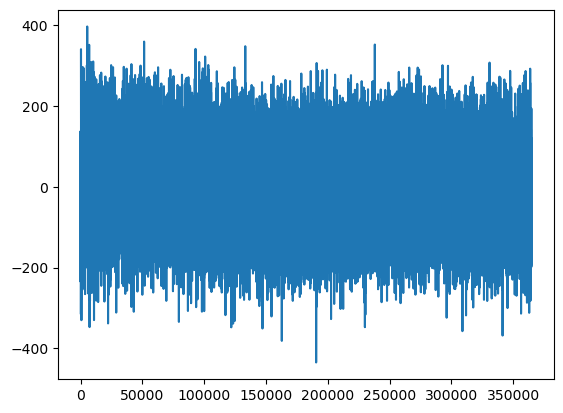

In [57]:
plt.plot(anoms_detrended.isel(lat=30,lon=50).Z_anom)

In [58]:
del(anoms_filtered)

In [59]:
clima_std = get_climatology_std_smoothed(anoms_detrended, 'Z_anom')
clima_std_average_region_series = get_weighted_area_average(clima_std)



In [60]:
anoms_standardized = copy.deepcopy(anoms_detrended).Z_anom
anoms_standardized.data = np.zeros_like(anoms_standardized.data)

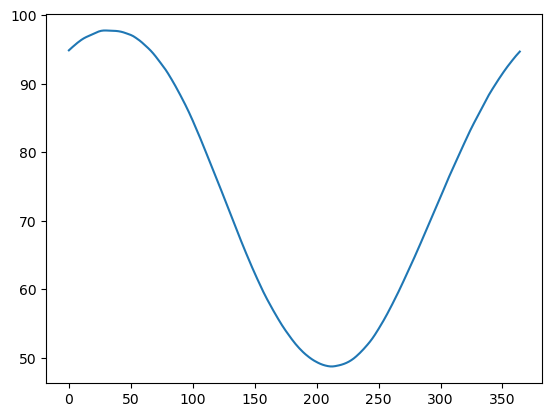

In [61]:
plt.plot(clima_std_average_region_series.Z_anom_climo_std)

In [62]:
doy_tmp = create_doy_dummy(len(np.unique(years_full)))

In [63]:
for i in range(0, 365): #Iterate through every day of the year

    doy_indx = doy_tmp[:, i]

    # grab doy std (climo)
    std_temp = clima_std_average_region_series.Z_anom_climo_std[i].data
    # standardize the detrended anoms by std climo
    standardized_temp = anoms_detrended.Z_anom[doy_indx].data / std_temp
    anoms_standardized.loc[{'time': anoms_detrended.Z_anom[doy_indx].time}] = standardized_temp

In [64]:
# anoms_standardized = anoms_standardized.to_dataset()
anoms_standardized.to_netcdf(f'/glade/derecho/scratch/jhayron/Data4WRsClimateChange/CESM2_4xCO2/anoms_standardized.nc')

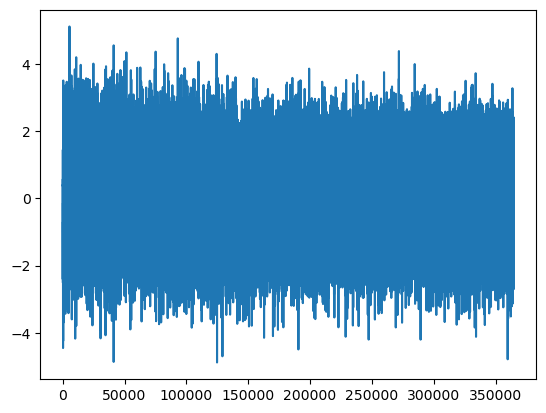

In [67]:
plt.plot(anoms_standardized.isel(lat=30,lon=50))

In [66]:
anoms_standardized

<xarray.DataArray 'Z_anom' (time: 364635, lat: 64, lon: 121)> Size: 23GB
array([[[ 9.25431344e-03, -9.45386505e-03, -3.03373740e-02, ...,
         -4.13052483e-01, -4.39185124e-01, -4.75064622e-01],
        [ 3.20375134e-02,  1.03268689e-02, -1.59046558e-02, ...,
         -3.81568239e-01, -4.15540671e-01, -4.56731318e-01],
        [ 5.47524288e-02,  2.88161070e-02,  6.84931049e-04, ...,
         -3.46526588e-01, -3.82230290e-01, -4.25559704e-01],
        ...,
        [-1.75900416e+00, -1.79049137e+00, -1.82256501e+00, ...,
         -1.74487564e+00, -1.77602335e+00, -1.85965275e+00],
        [-1.85412950e+00, -1.88980895e+00, -1.92586195e+00, ...,
         -1.85151979e+00, -1.91397270e+00, -1.91196803e+00],
        [-1.92237906e+00, -1.95946046e+00, -1.99810849e+00, ...,
         -1.94899877e+00, -1.94846258e+00, -1.94991978e+00]],

       [[-6.06011639e-01, -6.30998475e-01, -6.58451316e-01, ...,
         -9.46039667e-01, -9.60672516e-01, -9.84774795e-01],
        [-5.95212806e-01, -6.23492662e-01, -6.56173792e-01, ...,
         -9.22986788e-01, -9.45207368e-01, -9.73798221e-01],
        [-5.85601297e-01, -6.18025909e-01, -6.53624505e-01, ...,
         -8.98911855e-01, -9.22640770e-01, -9.51998532e-01],
...
        [-2.99100892e+00, -2.99834253e+00, -3.00620324e+00, ...,
         -2.43617288e+00, -2.45918811e+00, -2.51812920e+00],
        [-3.03034997e+00, -3.04773401e+00, -3.06539782e+00, ...,
         -2.49255404e+00, -2.53120642e+00, -2.52433435e+00],
        [-3.04681188e+00, -3.06801906e+00, -3.08970861e+00, ...,
         -2.51983178e+00, -2.51694151e+00, -2.50632219e+00]],

       [[-7.29351924e-01, -7.40471362e-01, -7.53591292e-01, ...,
         -1.22968300e+00, -1.25840100e+00, -1.29647275e+00],
        [-6.98878549e-01, -7.12408813e-01, -7.30288980e-01, ...,
         -1.19465658e+00, -1.22968421e+00, -1.27241035e+00],
        [-6.68667771e-01, -6.85774673e-01, -7.04480422e-01, ...,
         -1.15421740e+00, -1.19022162e+00, -1.23540905e+00],
        ...,
        [-3.06848457e+00, -3.09113868e+00, -3.11439354e+00, ...,
         -2.81658516e+00, -2.84451926e+00, -2.91876971e+00],
        [-3.13970791e+00, -3.16927229e+00, -3.19919437e+00, ...,
         -2.89930350e+00, -2.95231347e+00, -2.94893181e+00],
        [-3.18483819e+00, -3.21673957e+00, -3.24978264e+00, ...,
         -2.96404766e+00, -2.96350218e+00, -2.95956048e+00]]])
Coordinates:
  * lat      (lat) float64 512B 20.26 21.2 22.15 23.09 ... 77.75 78.69 79.63
  * lon      (lon) float64 968B 180.0 181.2 182.5 183.8 ... 327.5 328.8 330.0
  * time     (time) object 3MB 0001-01-01 00:00:00 ... 0999-12-31 00:00:00
Attributes:
    File Author:  Jhayron S. Pérez-Carrasquilla

In [73]:
id_experiment = 0
name_experiment = unique_names_experiments[id_experiment]
print(name_experiment)
where_files = np.where(names_experiments_all==name_experiment)[0]
files_temp = filenames[where_files]
dataset_raw = extractz500_several_files(files_temp)

LE2-1001.001_cmip6


/glade/derecho/scratch/jhayron/tmp/ipykernel_52022/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


In [74]:
lat0=20; lat1=80; lon0=180; lon1=330
dataset_region = dataset_raw.where(
    (
        dataset_raw.lat>=lat0)&(
            dataset_raw.lat<=lat1)&(
            dataset_raw.lon>=lon0)&(
            dataset_raw.lon<=lon1),
    drop=True
)

In [77]:
clima = get_climatology_smoothed(dataset_region, 'Z500')
anoms = get_anomalies(dataset_region, 'Z500', clima)

(365, 64, 121)
(365, 64, 121)


In [82]:
anoms_filtered = fourierfilter(anoms.Z500_anom)
anoms_filtered = anoms_filtered.to_dataset(name='Z_anom')

/glade/derecho/scratch/jhayron/tmp/ipykernel_52022/4011791934.py:110: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


In [88]:
anoms_smooth = copy.deepcopy(anoms_filtered).rolling(time=60, center=True, min_periods=1).mean(skipna=True)
mean_series = get_weighted_area_average(anoms_smooth.Z_anom)
full_curve = copy.deepcopy(mean_series)
full_curve.data = np.zeros(len(full_curve))
npoly=3

doy_tmp = create_doy_dummy(len(np.unique(pd.to_datetime(mean_series.time).year)))

for i in range(0, 365): #Iterate through every day of the year

    doy_indx = doy_tmp[:, i]
    
    # fit a polynomial for the trend of each DOY
    params_curve = polynomial.polyfit(
        np.arange(0, mean_series[doy_indx].shape[0]), 
        mean_series[doy_indx], 
        npoly
    )
    curve = polynomial.polyval(
        np.arange(0, mean_series[doy_indx].shape[0]), 
        params_curve, 
        tensor=True
    )
    
    ## Center curve in zero
    full_curve.loc[{'time': mean_series[doy_indx].time}] = curve

anoms_detrended = anoms_filtered.Z_anom - full_curve.data[:, np.newaxis, np.newaxis]
anoms_detrended = anoms_detrended.to_dataset()

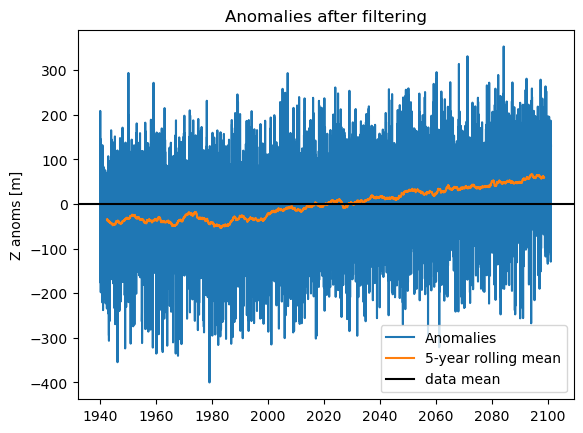

In [84]:
example_time_series = anoms_filtered.Z_anom.sel(lat=39, lon=-77 + 360,method='nearest')
plt.plot(
    example_time_series.time, 
    example_time_series, 
    label='Anomalies'
)
plt.plot(
    example_time_series.time, 
    example_time_series.rolling(time=5 * 365, center=True).mean(skipna=True), 
    label='5-year rolling mean'
)
plt.axhline(
    np.mean(example_time_series),
    color='k',
    label='data mean'
)
plt.title('Anomalies after filtering')
plt.ylabel('Z anoms [m]')
plt.legend()
plt.show()

Text(0, 0.5, 'Z [m]')

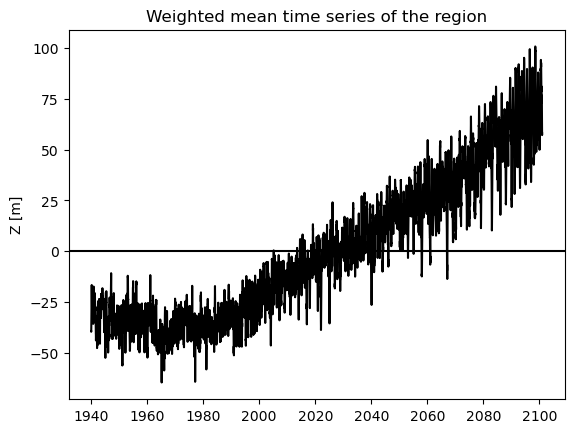

In [89]:
plt.plot(
    mean_series.time,
    mean_series,
    color='k'
)
plt.axhline(
    np.mean(mean_series),
    color='k'
)
plt.title('Weighted mean time series of the region')
plt.ylabel('Z [m]')

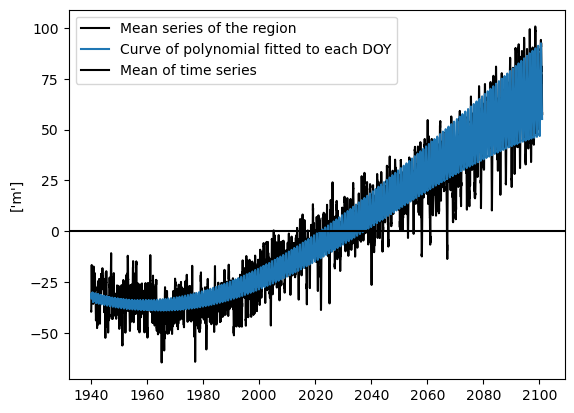

In [90]:
plt.plot(
    mean_series.time,
    mean_series,
    color='k',
    label='Mean series of the region'
)
plt.plot(
    full_curve.time,
    full_curve,
    label='Curve of polynomial fitted to each DOY'
)
plt.axhline(
    np.mean(mean_series),
    color='k',
    label='Mean of time series'
)
plt.ylabel(['m'])
plt.legend()
plt.show()

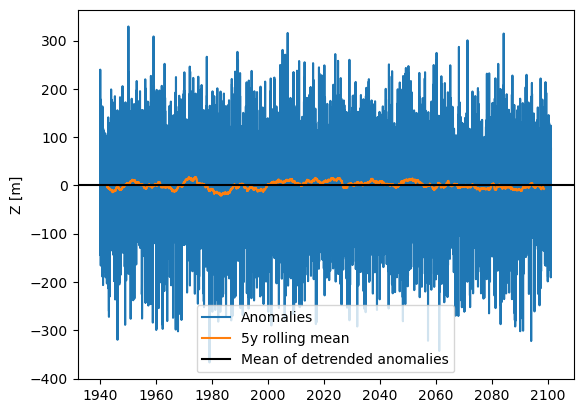

In [92]:
example_time_series = anoms_detrended.Z_anom.sel(lat=39, lon=-77 + 360,method='nearest')

plt.plot(
    example_time_series.time,
    example_time_series,
    label='Anomalies'
)
plt.plot(
    example_time_series.time,
    example_time_series.rolling(time=5 * 365,center=True).mean(skipna=True),
    label='5y rolling mean'
)
plt.axhline(
    np.mean(example_time_series),
    color='k',
    label='Mean of detrended anomalies'
)
plt.legend()
plt.ylabel('Z [m]')
plt.show()

In [93]:
clima_std = get_climatology_std_smoothed(anoms_detrended, 'Z_anom')
clima_std_average_region_series = get_weighted_area_average(clima_std)

anoms_standardized = copy.deepcopy(anoms_detrended).Z_anom
anoms_standardized.data = np.zeros_like(anoms_standardized.data)

doy_tmp = create_doy_dummy(len(np.unique(pd.to_datetime(mean_series.time).year)))

for i in range(0, 365): #Iterate through every day of the year

    doy_indx = doy_tmp[:, i]

    # grab doy std (climo)
    std_temp = clima_std_average_region_series.Z_anom_climo_std[i].data
    
    # standardize the detrended anoms by std climo
    standardized_temp = anoms_detrended.Z_anom[doy_indx].data / std_temp
    
    anoms_standardized.loc[{'time': anoms_detrended.Z_anom[doy_indx].time}] = standardized_temp

anoms_standardized = anoms_standardized.to_dataset()

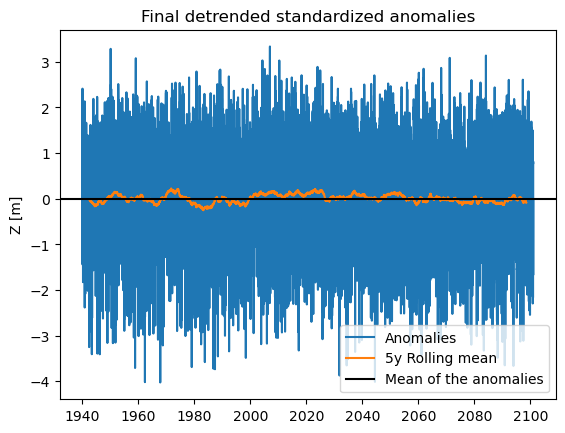

In [95]:
example_time_series = anoms_standardized.Z_anom.sel(lat=39, lon=-77 + 360,method='nearest')

plt.plot(
    example_time_series.time,
    example_time_series,
    label='Anomalies'
)
plt.plot(
    example_time_series.time,
    example_time_series.rolling(time=5 * 365, center=True).mean(skipna=True),
    label='5y Rolling mean'
)
plt.axhline(
    np.mean(example_time_series),
    color='k',
    label='Mean of the anomalies'
)
plt.legend()
plt.ylabel('Z [m]')
plt.title('Final detrended standardized anomalies')
plt.show()

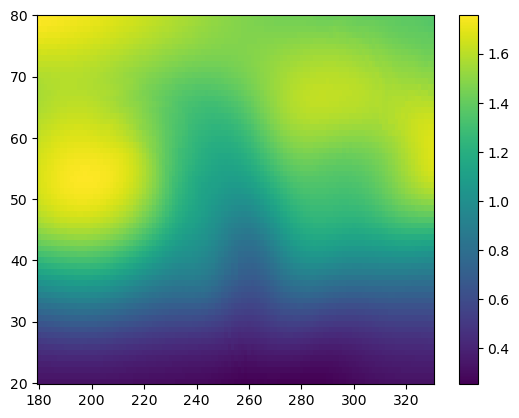

In [98]:
plt.pcolormesh(anoms_standardized.lon,anoms_standardized.lat,anoms_standardized.std('time').Z_anom)
plt.colorbar()
plt.show()

In [53]:
path_origins = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/'
name_reanalysis = 'ERA5'

for name_reanalysis in ['ERA5','JRA3Q','NCEP_NCAR']:
    dataset_raw = xr.open_dataset(
        f'{path_origins}Z500_{name_reanalysis}.nc'
    )
    lat0=20; lat1=80; lon0=180; lon1=330
    dataset_region = dataset_raw.where(
        (
            dataset_raw.lat>=lat0)&(
                dataset_raw.lat<=lat1)&(
                dataset_raw.lon>=lon0)&(
                dataset_raw.lon<=lon1),
        drop=True
    )
    
    dataset_region.Z.data = dataset_region.Z.data / 9.82 ### Divide by gravity to convert from m2/s2 to m
    
    clima = get_climatology_smoothed(dataset_region, 'Z')
    anoms = get_anomalies(dataset_region, 'Z', clima)
    
    anoms_filtered = fourierfilter(anoms.Z_anom)
    anoms_filtered = anoms_filtered.to_dataset(name='Z_anom')
    anoms_smooth = copy.deepcopy(anoms_filtered).rolling(time=60, center=True, min_periods=1).mean(skipna=True)
    mean_series = get_weighted_area_average(anoms_smooth.Z_anom)
    full_curve = copy.deepcopy(mean_series)
    full_curve.data = np.zeros(len(full_curve))
    npoly=3
    
    doy_tmp = create_doy_dummy(len(np.unique(pd.to_datetime(mean_series.time).year)))
    
    for i in range(0, 365): #Iterate through every day of the year
    
        doy_indx = doy_tmp[:, i]
        
        # fit a polynomial for the trend of each DOY
        params_curve = polynomial.polyfit(
            np.arange(0, mean_series[doy_indx].shape[0]), 
            mean_series[doy_indx], 
            npoly
        )
        curve = polynomial.polyval(
            np.arange(0, mean_series[doy_indx].shape[0]), 
            params_curve, 
            tensor=True
        )
        
        ## Center curve in zero
        full_curve.loc[{'time': mean_series[doy_indx].time}] = curve
    
    anoms_detrended = anoms_filtered.Z_anom - full_curve.data[:, np.newaxis, np.newaxis]
    anoms_detrended = anoms_detrended.to_dataset()
    clima_std = get_climatology_std_smoothed(anoms_detrended, 'Z_anom')
    clima_std_average_region_series = get_weighted_area_average(clima_std)
    
    anoms_standardized = copy.deepcopy(anoms_detrended).Z_anom
    anoms_standardized.data = np.zeros_like(anoms_standardized.data)
    
    doy_tmp = create_doy_dummy(len(np.unique(pd.to_datetime(mean_series.time).year)))
    
    for i in range(0, 365): #Iterate through every day of the year
    
        doy_indx = doy_tmp[:, i]
    
        # grab doy std (climo)
        std_temp = clima_std_average_region_series.Z_anom_climo_std[i].data
        
        # standardize the detrended anoms by std climo
        standardized_temp = anoms_detrended.Z_anom[doy_indx].data / std_temp
        
        anoms_standardized.loc[{'time': anoms_detrended.Z_anom[doy_indx].time}] = standardized_temp
    
    anoms_standardized = anoms_standardized.to_dataset()
    anoms_standardized.to_netcdf(f'{path_origins}Z500Anoms_{name_reanalysis}.nc')

(365, 61, 151)
(365, 61, 151)


/glade/derecho/scratch/jhayron/tmp/ipykernel_15480/1441930984.py:115: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


(365, 61, 151)
(365, 61, 151)


/glade/derecho/scratch/jhayron/tmp/ipykernel_15480/1441930984.py:115: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


(365, 25, 61)
(365, 25, 61)


/glade/derecho/scratch/jhayron/tmp/ipykernel_15480/1441930984.py:115: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
